In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import glob
import os
import math
import xarray as xr
import itertools
from dateutil.relativedelta import relativedelta
from datacube.utils import geometry
from datacube.utils.geometry import CRS
import datacube 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from shapely.geometry import Point, LineString, MultiPoint
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from sklearn.metrics import mean_squared_error
from scipy import stats

from otps import TimePoint
from otps import predict_tide
from datetime import datetime, timedelta
from datacube.utils.geometry import CRS

def tidal_tag(ds, tidepost_lat=None, tidepost_lon=None, swap_dims=False):
    
    if not tidepost_lat or not tidepost_lon:
        
        tidepost_lon, tidepost_lat = ds.extent.centroid.to_crs(crs=CRS('EPSG:4326')).coords[0]
        print(f'Setting tide post from dataset centroid: {tidepost_lon}, {tidepost_lat}')
        
    else:
        print(f'Using user-supplied tide post: {tidepost_lon}, {tidepost_lat}')
    
    # Use the tidal mode to compute tide heights for each observation:
    obs_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()
    obs_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in obs_datetimes]
    obs_predictedtides = predict_tide(obs_timepoints)
    obs_tideheights = [predictedtide.tide_m for predictedtide in obs_predictedtides]

    # Assign tide heights to the dataset as a new variable
    ds['tide_heights'] = xr.DataArray(obs_tideheights, [('time', ds.time)])
    
    # If swap_dims = True, make tide height the primary dimension instead of time
    if swap_dims:
        
        # Swap dimensions and sort by tide height
        ds = ds.swap_dims({'time': 'tide_heights'})
        ds = ds.sortby('tide_heights')        
    
    return ds

# Define custom functions
def water_indices(ds, water_index='NDWI', custom_varname=None, source='Collection2'): 
    
    """
    Takes an xarray dataset containing spectral bands, calculates one of a 
    series of water indices, and adds the resulting array as a new variable 
    in the original dataset.    

    Last modified: July 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------  
    ds : xarray Dataset
        A two-dimensional or multi-dimensional array with spectral bands named 
        'red', 'green', 'blue', 'nir', 'swir1' or 'swir2'. These bands are used
        as inputs to calculate the selected water index.
    water_index : str, optional
        A string giving the name of the water index to calculate. Valid options:
        'NDWI' (Normalised Difference Water Index, McFeeters 1996), 
        'MNDWI' (Modified Normalised Difference Water Index, Xu 1996), 
        'AWEI_ns (Automated Water Extraction Index - no shadows, Feyisa 2014)',
        'AWEI_sh' (Automated Water Extraction Index - shadows, Feyisa 2014), 
        'WI' (Water Index, Fisher 2016) & 'TCW' (Tasseled Cap Wetness, Crist 1985).
        Defaults to 'NDWI'.        
    custom_varname : str, optional
        By default, the function will return the original dataset with a new
        water index variable named after `water_index` (e.g. NDWI). To specify
        a custom name instead, you can supply e.g. `custom_varname='water_index'`. 

    Returns
    -------
    ds : xarray Dataset
        The original xarray Dataset inputted into the function, with a new band
        containing the water index DataArray.
    """           
   
    # Dictionary containing water index band recipes
    water_index_dict = {# Normalised Difference Water Index, McFeeters 1996
                        'NDWI': lambda ds: (ds.green - ds.nir) / (ds.green + ds.nir),
        
                        # Modified Normalised Difference Water Index, Xu 2006
                        'MNDWI': lambda ds: (ds.green - ds.swir1) / (ds.green + ds.swir1),
        
                        # Automated Water Extraction Index (no shadows), Feyisa 2014
                        'AWEI_ns': lambda ds: (4 * (ds.green - ds.swir1) -
                                               (2.5 * ds.nir * + 2.75 * ds.swir2)),
        
                        # Automated Water Extraction Index (shadows), Feyisa 2014
                        'AWEI_sh': lambda ds: (ds.blue + 2.5 * ds.green - 
                                               1.5 * (ds.nir + ds.swir1) - 2.5 * ds.swir2),
    
                        # Water Index, Fisher 2016
                        'WI': lambda ds: (1.7204 + 171 * ds.green + 3 * ds.red + 
                                          70 * ds.nir - 45 * ds.swir1 - 71 * ds.swir2),
        
                        # Tasseled Cap Wetness, Crist 1985
                        'TCW': lambda ds: (0.0315 * ds.blue + 0.2021 * ds.green + 
                                           0.3102 * ds.red + 0.1594 * ds.nir - 
                                           0.6806 * ds.swir1 - 0.6109 * ds.swir2)} 
    
    # Select a water index function based on 'water_index'    
    water_index_func = water_index_dict[water_index]
    
    # Rename bands to a consistent format if either 'Collection3'
    # or 'Sentinel2' is specified by `source`
    if source == 'Collection3':
        
        # Dictionary mapping full data names to simpler 'red' alias names
        bandnames_dict = {'nbart_red': 'red', 'nbart_green': 'green',
                          'nbart_blue': 'blue', 'nbart_nir': 'nir',
                          'nbart_swir_1': 'swir1', 'nbart_swir_2': 'swir2',
                          'nbar_red': 'red', 'nbar_green': 'green',
                          'nbar_blue': 'blue', 'nbar_nir': 'nir', 
                          'nbar_swir_1': 'swir1', 'nbar_swir_2': 'swir2'}

        # Rename bands in dataset to use simple names (e.g. 'red')
        bands_to_rename = {a: b for a, b in bandnames_dict.items() if a in ds.variables}
        
    elif source == 'Sentinel2':
        
        # Dictionary mapping full data names to simpler 'red' alias names
        bandnames_dict = {'nbart_red': 'red', 'nbart_green': 'green',
                          'nbart_blue': 'blue', 'nbart_nir': 'nir',
                          'nbart_swir_2': 'swir1', 'nbart_swir_3': 'swir2',
                          'nbar_red': 'red', 'nbar_green': 'green',
                          'nbar_blue': 'blue', 'nbar_nir': 'nir',
                          'nbar_swir_2': 'swir1', 'nbar_swir_3': 'swir2'}

        # Rename bands in dataset to use simple names (e.g. 'red')
        bands_to_rename = {a: b for a, b in bandnames_dict.items() if a in ds.variables}

    elif source == 'Collection2':
        
        # For the DEA Collection 2, pass an empty dict as no bands need renaming
        bands_to_rename = {}

    
    # Apply water index function to data and add to input dataset. If a custom name
    # is supplied for the output water index variable, use it.
    if custom_varname:        
        
        # Apply function after normalising to a 0.0-1.0 range by dividing by 10,000
        ds[custom_varname] = water_index_func(ds.rename(bands_to_rename) / 10000.0)
        
    else:
        
        # Apply function after normalising to a 0.0-1.0 range by dividing by 10,000
        ds[water_index] = water_index_func(ds.rename(bands_to_rename) / 10000.0)
    
    # Return input dataset with added water index variable
    return ds


# Connect to datacube database
dc_ard = datacube.Datacube(config='/home/561/rt1527/.ard-interoperability_tmp.conf')
dc = datacube.Datacube()

import sys
sys.path.append('../10_Scripts')
import DEAPlotting, SpatialTools

%load_ext autoreload
%autoreload 2


## Extract waterlines for site
To do: look into one pixel leftward offset

In [2]:
site = 'Stockton'
shoreline_dist = pd.read_csv(f'/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/processed/validation_{site}.csv')
shoreline_dist['date'] = pd.to_datetime(shoreline_dist.date)

xmin, xmax = shoreline_dist.loc[:, ['origin_x', 'end_x']].melt()['value'].quantile([0, 1.0])
ymin, ymax = shoreline_dist.loc[:, ['origin_y', 'end_y']].melt()['value'].quantile([0, 1.0])

DEAPlotting.display_map(x=(xmin, xmax), y=(ymin, ymax), crs='EPSG:28356')
shoreline_dates = shoreline_dist['date'].unique()
shoreline_dates.sort()

DEAPlotting.display_map(x=(xmin, xmax), y=(ymin, ymax), crs='EPSG:32756')

In [10]:
collection = 'Collection upgrade align'

# Set up query
query = {'x': (xmin - 100, xmax + 100),
         'y': (ymin - 100, ymax + 100),
         'time': ('1987-01-01', '2019-12-29'),
         'crs': 'EPSG:28356'}

xarray_dict = {}

for sensor in ['ls5', 'ls7', 'ls8']:

    # Load data in UTM zone coordinates
    landsat_ds = dc_ard.load(product = f'{sensor}_ard', 
                         group_by = 'solar_day', 
                         output_crs = 'EPSG:28356',
                         measurements = ['nbart_green', 'nbart_nir', 'nbart_swir_1',  'fmask'],
                         resolution = (-30, 30),
                         dask_chunks={'time': 1},
                         align=(30/2.0, 30/2.0),
                         **query)

    # Identify pixels with valid data: no nodata, no cloud and no cloud shadow
    good_quality = ((landsat_ds.fmask != 0) & 
                    (landsat_ds.fmask != 2) & 
                    (landsat_ds.fmask != 3))

    # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
    landsat_ds = landsat_ds.where(good_quality)

    # Compute NDWI and MNDWI 
    landsat_ds['NDWI'] = (landsat_ds.nbart_green - landsat_ds.nbart_nir) / (landsat_ds.nbart_green + landsat_ds.nbart_nir)
    landsat_ds['MNDWI'] = (landsat_ds.nbart_green - landsat_ds.nbart_swir_1) / (landsat_ds.nbart_green + landsat_ds.nbart_swir_1)
#     landsat_ds = water_indices(landsat_ds, water_index='AWEI_ns', custom_varname='water_index')
    
    xarray_dict[sensor] = landsat_ds
    
landsat_ds = xr.concat(xarray_dict.values(), dim='time')[['MNDWI', 'NDWI']]
landsat_ds = landsat_ds.sortby('time')

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series

In [7]:
landsat_ds

<xarray.Dataset>
Dimensions:  (time: 958, x: 35, y: 106)
Coordinates:
  * y        (y) float64 6.269e+06 6.269e+06 6.269e+06 ... 6.266e+06 6.266e+06
  * x        (x) float64 3.424e+05 3.424e+05 3.424e+05 ... 3.434e+05 3.434e+05
  * time     (time) datetime64[ns] 1987-05-22T23:07:44.180074 ... 2019-02-07T23:43:52.616068
Data variables:
    MNDWI    (time, y, x) float64 dask.array<shape=(958, 106, 35), chunksize=(1, 106, 35)>
    NDWI     (time, y, x) float64 dask.array<shape=(958, 106, 35), chunksize=(1, 106, 35)>
Attributes:
    crs:      EPSG:28356

In [5]:
collection = 'Current collection'

# Set up query
query = {'x': (xmin - 100, xmax + 100),
         'y': (ymin - 100, ymax + 100),
         'time': ('1987-01-01', '2019-12-29'),
         'crs': 'EPSG:32756'}

xarray_dict = {}

for sensor in ['ls5', 'ls7', 'ls8']:

    # Load data 
    landsat_ds = dc.load(product = f'{sensor}_nbart_albers', 
                         group_by = 'solar_day', 
                         output_crs = 'EPSG:32756',
                         measurements = ['green', 'nir', 'swir1', 'swir2'],
                         resolution = (-30, 30),
                         resampling='bilinear',
                         dask_chunks={'time': 1},
                         **query)

    # Load data in UTM zone coordinates
    landsat_pq = dc.load(product = f'{sensor}_pq_albers', 
                         group_by = 'solar_day', 
                         output_crs = 'EPSG:32756',
                         measurements = ['pixelquality'],
                         resolution = (-30, 30),
                         resampling='nearest',
                         dask_chunks={'time': 1},
                         **query)                       

    # Return only Landsat observations that have matching PQ data 
    time = (landsat_ds.time - landsat_pq.time).time
    landsat_ds = landsat_ds.sel(time=time)
    landsat_pq = landsat_pq.sel(time=time)

    # Create mask
    good_quality = masking.make_mask(landsat_pq.pixelquality,
                                     cloud_acca='no_cloud',
                                     cloud_shadow_acca='no_cloud_shadow',
                                     cloud_shadow_fmask='no_cloud_shadow',
                                     cloud_fmask='no_cloud',
                                     blue_saturated=False,
                                     green_saturated=False,
                                     red_saturated=False,
                                     nir_saturated=False,
                                     swir1_saturated=False,
                                     swir2_saturated=False,
                                     contiguous=True) 
    
    # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
    landsat_ds = landsat_ds.where(good_quality)

    # Compute NDWI and MNDWI 
#     landsat_ds['NDWI'] = (landsat_ds.green - landsat_ds.nir) / (landsat_ds.green + landsat_ds.nir)
#     landsat_ds['MNDWI'] = (landsat_ds.green - landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1)
    landsat_ds = water_indices(landsat_ds, water_index='AWEI_ns', custom_varname='water_index', source='Collection2')    
    
    xarray_dict[sensor] = landsat_ds
    
landsat_ds = xr.concat(xarray_dict.values(), dim='time')[['water_index']]
landsat_ds = landsat_ds.sortby('time')

## Annual composites

In [6]:
# Pull out selected years
years_to_analyse = shoreline_dist.date.dt.year.unique(); print(years_to_analyse)
landsat_subset = xr.concat([landsat_ds.sel(time=str(i)) for i in years_to_analyse], dim='time')

# Compute tides
landsat_subset = tidal_tag(landsat_subset)
landsat_subset = landsat_subset.sortby('tide_heights') 

# Filter
landsat_subset = landsat_subset.sel(time = landsat_subset.tide_heights > (landsat_subset.tide_heights).median())

# Tide_adj
datum = 0.5
landsat_subset['adj_0.01'] = ((datum - landsat_subset.tide_heights) / -0.01)
landsat_subset['adj_0.05'] = ((datum - landsat_subset.tide_heights) / -0.05)
landsat_subset['adj_0.10'] = ((datum - landsat_subset.tide_heights) / -0.10)
landsat_subset['adj_0.20'] = ((datum - landsat_subset.tide_heights) / -0.20)

# Load data into memory and take median
out = landsat_subset.compute().groupby('time.year').median(dim='time')


[1991 1994 1996 1999 2001 2016 2018 1997]
Setting tide post from dataset centroid: 151.78991114186223, -32.90572542252326


In [ ]:
# landsat_subset.compute()

In [ ]:
# out = []
# for year in years_to_analyse:

#     annual_subset = landsat_subset.sel(time=str(year))

#     diff = 100
#     annual_mediantide = None

#     if annual_subset.tide_heights.median() > 0:

#         for i in range(0, len(annual_subset.tide_heights) + 1):

#             val = annual_subset.isel(time = slice(0, len(annual_subset.tide_heights) - i)).tide_heights.median().item()

#             if abs(val) < diff:

#                 diff = abs(val)
#                 annual_mediantide = annual_subset.isel(time = slice(0, len(annual_subset.tide_heights) - i))
                
#         out.append(annual_mediantide)

# # Load data into memory and take median
# landsat_subset = xr.concat(out, dim='time')
# out = landsat_subset.compute().groupby('time.year').median(dim='time')


In [71]:
custom_attrs = {'year': out.year.values.tolist(),
                'tide': out.tide_heights.values.tolist(),
                'adj_0.01': out['adj_0.01'].values.tolist(),
                'adj_0.05': out['adj_0.05'].values.tolist(),
                'adj_0.10': out['adj_0.10'].values.tolist(),
                'adj_0.20': out['adj_0.20'].values.tolist()}
custom_attrs_dtypes = {'year': 'int', 'tide': 'float', 'adj_0.01': 'float', 'adj_0.05': 'float', 'adj_0.10': 'float', 'adj_0.20': 'float'}

metric = 'water_index'
metric_thresh = 0

# Extract contours with custom attribute fields:
contour_gdf = SpatialTools.contour_extract(z_values=metric_thresh,
                                           ds_array=out[metric],
                                           ds_crs=landsat_ds.geobox.crs,
                                           ds_affine=landsat_ds.geobox.affine,
                                           output_shp=f'validation/outputs/landsat_contours_{site}.shp',
                                           attribute_data=custom_attrs,
                                           attribute_dtypes=custom_attrs_dtypes,
                                           min_vertices=2,
                                           verbose=False, dim='year')

Operating in single z-value, multiple arrays mode
Exporting contour shapefile to validation/outputs/landsat_contours_Stockton.shp


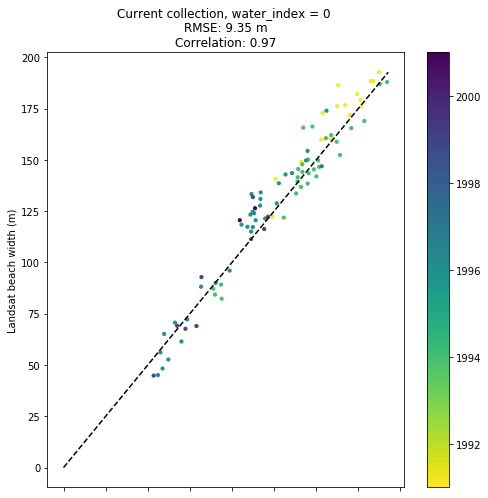

In [76]:
# Import waterline contours
contours_gdf = gpd.read_file(f'validation/outputs/landsat_contours_{site}.shp')
contours_gdf = contours_gdf.to_crs(epsg=28356)  

# contours_gdf = gpd.read_file(f'/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/output_data/stockton/stockton_AWEI_ns_-0.25.shp')
# contours_gdf['year'] = contours_gdf.timeperiod.str[0:4].astype(int)

# Subset to AHD 0.0 data
shoreline_ahd0 = shoreline_dist[['site', 'date', 'ahd0.5_dist', 'ahd0.0_x', 'ahd0.0_y', 
                                 'origin_x', 'origin_y', 'end_x', 'end_y', 'foredune_x', 'foredune_y']].dropna()
shoreline_ahd0['year']= shoreline_dist.date.dt.year

# Reduce to year
counts = shoreline_ahd0.groupby([shoreline_ahd0.year, 'site']).count().date
shoreline_ahd0 = shoreline_ahd0.groupby([shoreline_ahd0.year, 'site']).median()
shoreline_ahd0['n'] = counts
shoreline_ahd0 = shoreline_ahd0.reset_index()

# Create geometry for shoreline transects
# shoreline_ahd0_geometry  = shoreline_ahd0.apply(lambda x: LineString([Point(x.origin_x, x.origin_y), Point(x.end_x, x.end_y)]), axis = 1)
shoreline_ahd0_geometry  = shoreline_ahd0.apply(lambda x: LineString([Point(x.foredune_x, x.foredune_y), 
                                                                      Point(x.end_x, x.end_y)]), axis = 1)
shoreline_ahd0_gdf = gpd.GeoDataFrame(shoreline_ahd0, geometry=shoreline_ahd0_geometry).reset_index()
shoreline_ahd0_gdf.crs = 'EPSG:28356'

# Combine to match each shoreline contour to each date in validation data
merge_test = shoreline_ahd0_gdf.merge(contours_gdf, on='year')

# For each row, compute distance between origin and location where profile intersects with waterline contour
merge_test['Landsat beach width (m)'] = merge_test.apply(lambda x: x.geometry_x.intersection(x.geometry_y).hausdorff_distance(Point(x.origin_x, x.origin_y)), axis=1)
merge_test = merge_test.rename({'ahd0.5_dist': 'Validation beach width (m)'}, axis=1)
merge_test = merge_test[merge_test['Landsat beach width (m)'] > 0]
merge_test = merge_test[merge_test['Validation beach width (m)'] > 0]

# Optional adjustment for tides
# merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + merge_test['adj_0.10'] 

# Compute difference
merge_test['Difference'] = merge_test['Validation beach width (m)'] - merge_test['Landsat beach width (m)'] 

merge_test = merge_test[merge_test['Landsat beach width (m)'] < 200]
merge_test = merge_test[merge_test['Validation beach width (m)'] < 200]
merge_test = merge_test[merge_test.n > 0]
merge_test.head()


# Plot
# merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + 25
rmse = np.round(mean_squared_error(merge_test['Validation beach width (m)'], merge_test['Landsat beach width (m)'])**0.5, 2)
cor = np.round(merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].corr().iloc[0, 1], 2)
dist_lim = merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].max(axis=0).max()
merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].plot.scatter(x='Validation beach width (m)', 
                                                                                   y='Landsat beach width (m)', 
                                                                                   c=merge_test.year, s=10, cmap='viridis_r', figsize=(8, 8))  
plt.plot(np.linspace(0, dist_lim), np.linspace(0, dist_lim), 'black', linestyle='dashed')
plt.title(f'{collection}, {metric} = {metric_thresh} \nRMSE: {rmse} m\nCorrelation: {cor}')
plt.savefig(f"{site}_{collection.lower().replace(' ', '')}_{metric}_{metric_thresh}.png")


Text(0, 0.5, 'Beach width (m)')

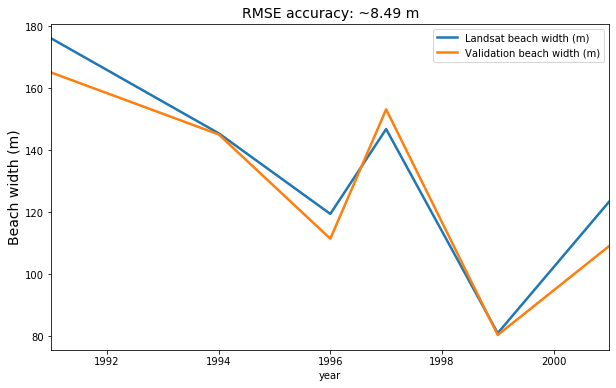

In [77]:
selected_site = merge_test.groupby('year').median().reset_index()  
rmse = np.round(mean_squared_error(selected_site['Validation beach width (m)'], selected_site['Landsat beach width (m)'])**0.5, 2)

(selected_site
 .plot.line(x='year', 
            y=['Landsat beach width (m)', 'Validation beach width (m)'], 
            figsize=(10,6), linewidth=2.5))

plt.title(f'RMSE accuracy: ~{rmse} m', fontsize=(14))
plt.gca().set_ylabel('Beach width (m)', fontsize=(14))


In [63]:
merge_test

,index,year,site,Validation beach width (m),ahd0.0_x,ahd0.0_y,origin_x,origin_y,end_x,end_y,...,n,geometry_x,tide,adj_0.01,adj_0.05,adj_0.10,adj_0.20,geometry_y,Landsat beach width (m),Difference
1,1,1991,Stockton_A_10,152.946377,386873.365068,6.357698e+06,386732.03,6357624.46,386874.97,6357698.71,...,1,"LINESTRING (386824.32 6357672.39, 386874.97 63...",0.5425,4.25,0.85,0.425,0.2125,(LINESTRING (386725.0444359325 6359835.0001015...,159.919288,-6.972911
6,6,1991,Stockton_A_15,158.485904,386786.080363,6.357878e+06,386639.87,6357801.90,386786.54,6357878.09,...,1,"LINESTRING (386736.63 6357852.16, 386786.54 63...",0.5425,4.25,0.85,0.425,0.2125,(LINESTRING (386725.0444359325 6359835.0001015...,160.509875,-2.023971
9,9,1991,Stockton_A_18,176.338475,386744.632880,6.357992e+06,386584.56,6357908.36,386745.98,6357992.21,...,1,"LINESTRING (386643.52 6357938.99, 386745.98 63...",0.5425,4.25,0.85,0.425,0.2125,(LINESTRING (386725.0444359325 6359835.0001015...,179.303874,-2.965399
10,10,1991,Stockton_A_19,184.007064,386733.301931,6.358031e+06,386566.13,6357943.85,386737.97,6358033.11,...,1,"LINESTRING (386579.88 6357951, 386737.97 63580...",0.5425,4.25,0.85,0.425,0.2125,(LINESTRING (386725.0444359325 6359835.0001015...,188.396316,-4.389252
13,13,1991,Stockton_A_3,153.795081,387004.518163,6.357451e+06,386861.07,6357376.04,387048.23,6357473.26,...,1,"LINESTRING (386973.31 6357434.35, 387048.23 63...",0.5425,4.25,0.85,0.425,0.2125,(LINESTRING (386725.0444359325 6359835.0001015...,172.924351,-19.129270
14,14,1991,Stockton_A_4,162.987200,387003.675091,6.357495e+06,386842.64,6357411.53,387020.51,6357503.92,...,1,"LINESTRING (386855.77 6357418.36, 387020.51 63...",0.5425,4.25,0.85,0.425,0.2125,(LINESTRING (386725.0444359325 6359835.0001015...,186.357764,-23.370564
15,15,1991,Stockton_A_5,174.370317,386990.077850,6.357533e+06,386824.20,6357447.02,387000.05,6357538.36,...,1,"LINESTRING (386897.22 6357484.95, 387000.05 63...",0.5425,4.25,0.85,0.425,0.2125,(LINESTRING (386725.0444359325 6359835.0001015...,182.052005,-7.681687
16,16,1991,Stockton_A_6,176.885515,386968.304592,6.357567e+06,386805.77,6357482.51,386973.49,6357569.63,...,1,"LINESTRING (386890.14 6357526.33, 386973.49 63...",0.5425,4.25,0.85,0.425,0.2125,(LINESTRING (386725.0444359325 6359835.0001015...,176.156879,0.728636
17,17,1991,Stockton_A_7,167.230165,386942.058396,6.357598e+06,386787.33,6357518.00,386948.78,6357601.85,...,1,"LINESTRING (386879.38 6357565.81, 386948.78 63...",0.5425,4.25,0.85,0.425,0.2125,(LINESTRING (386725.0444359325 6359835.0001015...,176.776211,-9.546046
18,18,1991,Stockton_A_8,162.464535,386918.980259,6.357631e+06,386768.90,6357553.48,386925.27,6357634.71,...,1,"LINESTRING (386861.14 6357601.4, 386925.27 635...",0.5425,4.25,0.85,0.425,0.2125,(LINESTRING (386725.0444359325 6359835.0001015...,176.096320,-13.631785


In [ ]:
shoreline_ahd0_gdf.to_file(f'validation/outputs/validation_transect_{site}.shp')

In [ ]:
cols = ['year', 'site', 'origin_x', 'origin_y', 'ahd0.0_x', 'ahd0.0_y', 'Validation beach width (m)', 'Landsat beach width (m)', 'Difference']
merge_test.reindex(merge_test.Difference.abs().sort_values().index)[cols].tail(5)

In [ ]:
# ndwi_median = landsat_subset.sel(time='2018').compute().median(dim='time')  #.plot()
# ndwi_median.attrs['crs'] = landsat_subset.crs
# # from datacube.helpers import write_geotiff
# write_geotiff(filename='test_ndwi.tif', dataset=ndwi_median[['NDWI']])


In [ ]:

geometry_intersect = merge_test.apply(lambda x: x.geometry_x.intersection(x.geometry_y), axis=1)
# geometry_intersect
intersect_ahd0_gdf = gpd.GeoDataFrame(merge_test[['year', 'site']], geometry=geometry_intersect).reset_index()
intersect_ahd0_gdf[intersect_ahd0_gdf.site == 'Avoca_5_1']
# intersect_ahd0_gdf.crs = 'EPSG:28356'
# intersect_ahd0_gdf.to_file(f'validation/outputs/validation_intersect_{site}.shp')

In [ ]:
# merge_test.apply(lambda x: MultiPoint([x.geometry_x.intersection(x.geometry_y)]), axis=1)

In [ ]:
# merge_test.apply(lambda x: x.geometry_x.intersection(x.geometry_y), axis=1)

## Individual observations

In [ ]:
out = landsat_ds.sel(time=shoreline_dates, method='nearest')
out['time_diff'] = (out.time - shoreline_dates) 
out
# out.time_diff  < np.timedelta64(5,'D')

In [ ]:
out = out.compute()
out

In [ ]:
out = tidal_tag(out)
height = out['tide_heights']
slope = 90
out['x_adj'] = height * math.sin(np.deg2rad(90 - slope)) / math.sin(np.deg2rad(slope))

In [ ]:
custom_attrs = {'date': [str(i)[0:10] for i in shoreline_dates],
                'x_adj': out['x_adj'].values,
                'time_diff': out['time_diff'].values.astype('timedelta64[D]').astype('int16').tolist()
               }
custom_attrs_dtypes = {'date': 'str', 'x_adj': 'int', 'time_diff': 'int'}

# Extract contours with custom attribute fields:
contour_gdf = SpatialTools.contour_extract(z_values=0.0,
                                           ds_array=out.MNDWI,
                                           ds_crs=landsat_ds.geobox.crs,
                                           ds_affine=landsat_ds.geobox.affine,
                                           output_shp=f'validation/outputs/landsat_contours_{site}.shp',
                                           attribute_data=custom_attrs,
                                           attribute_dtypes=custom_attrs_dtypes,
                                           verbose=False)



In [ ]:
# Import waterline contours
contours_gdf = gpd.read_file(f'validation/outputs/landsat_contours_{site}.shp')
contours_gdf = contours_gdf.to_crs(epsg=28356)  
contours_gdf['date'] = pd.to_datetime(contours_gdf.date)

# Subset to AHD 0.0 data
shoreline_ahd0 = shoreline_dist[['date', 'ahd0.0_dist', 'origin_x', 'origin_y', 'end_x', 'end_y']].dropna()
shoreline_ahd0_geometry  = shoreline_ahd0.apply(lambda x: LineString([Point(x.origin_x, x.origin_y), Point(x.end_x, x.end_y)]), axis = 1)
shoreline_ahd0_gdf = gpd.GeoDataFrame(shoreline_ahd0, geometry=shoreline_ahd0_geometry).reset_index()
shoreline_ahd0_gdf.crs = 'EPSG:28356'

# Combine to match each shoreline contour to each date in validation data
merge_test = shoreline_ahd0_gdf.merge(contours_gdf, on='date')

# For each row, compute distance between origin and location where profile intersects with waterline contour
merge_test['Landsat beach width (m)'] = merge_test.apply(lambda x: x.geometry_x.intersection(x.geometry_y).distance(Point(x.origin_x, x.origin_y)), axis=1)
merge_test = merge_test.rename({'ahd0.0_dist': 'Validation beach width (m)'}, axis=1)
merge_test = merge_test[merge_test['Landsat beach width (m)'] > 0]
merge_test.head()

# Modify
merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)']  + merge_test['x_adj']

# Plot
# merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + 25
dist_lim = merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].max(axis=0).max()
merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].plot.scatter(x='Validation beach width (m)', 
                                                                                   y='Landsat beach width (m)', 
                                                                                   c=abs(merge_test.time_diff), s=1, cmap='viridis', figsize=(8, 8))  #
plt.plot(np.linspace(0, dist_lim), np.linspace(0, dist_lim), 'black', linestyle='dashed')
plt.ylim([0, dist_lim]); plt.xlim([0, dist_lim]);


In [ ]:

stats_df = merge_test[(np.abs(stats.zscore(merge_test[['Validation beach width (m)', 'Landsat beach width (m)']])) < 1).all(axis=1)]


mean_squared_error(stats_df['Validation beach width (m)'], stats_df['Landsat beach width (m)'])**0.5

In [ ]:
# merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + 25
dist_lim = stats_df[['Validation beach width (m)', 'Landsat beach width (m)']].max(axis=0).max()
stats_df[['Validation beach width (m)', 'Landsat beach width (m)']].plot.scatter(x='Validation beach width (m)', 
                                                                                   y='Landsat beach width (m)', 
                                                                                   c=abs(stats_df.time_diff), s=1, cmap='viridis', figsize=(8, 8))  #
plt.plot(np.linspace(0, dist_lim), np.linspace(0, dist_lim), 'black', linestyle='dashed')
plt.ylim([0, dist_lim]); plt.xlim([0, dist_lim]);